### Imports

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import manifold
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.lines import Line2D
%config InlineBackend.figure_format='retina'

# CERN modules
import fillingpatterns as fp

# Improve style
sns.set_theme(style="whitegrid")


### Load filling scheme and analyse beam-beam schedule with FillingPatterns

In [2]:
# Load filling scheme
fname = "../master_jobs/filling_scheme/8b4e_1972b_1960_1178_1886_224bpi_12inj_800ns_bs200ns.json"
patt = fp.FillingPattern.from_json(fname)


Computing collision schedules...
Done Beam 1
Done Beam 2


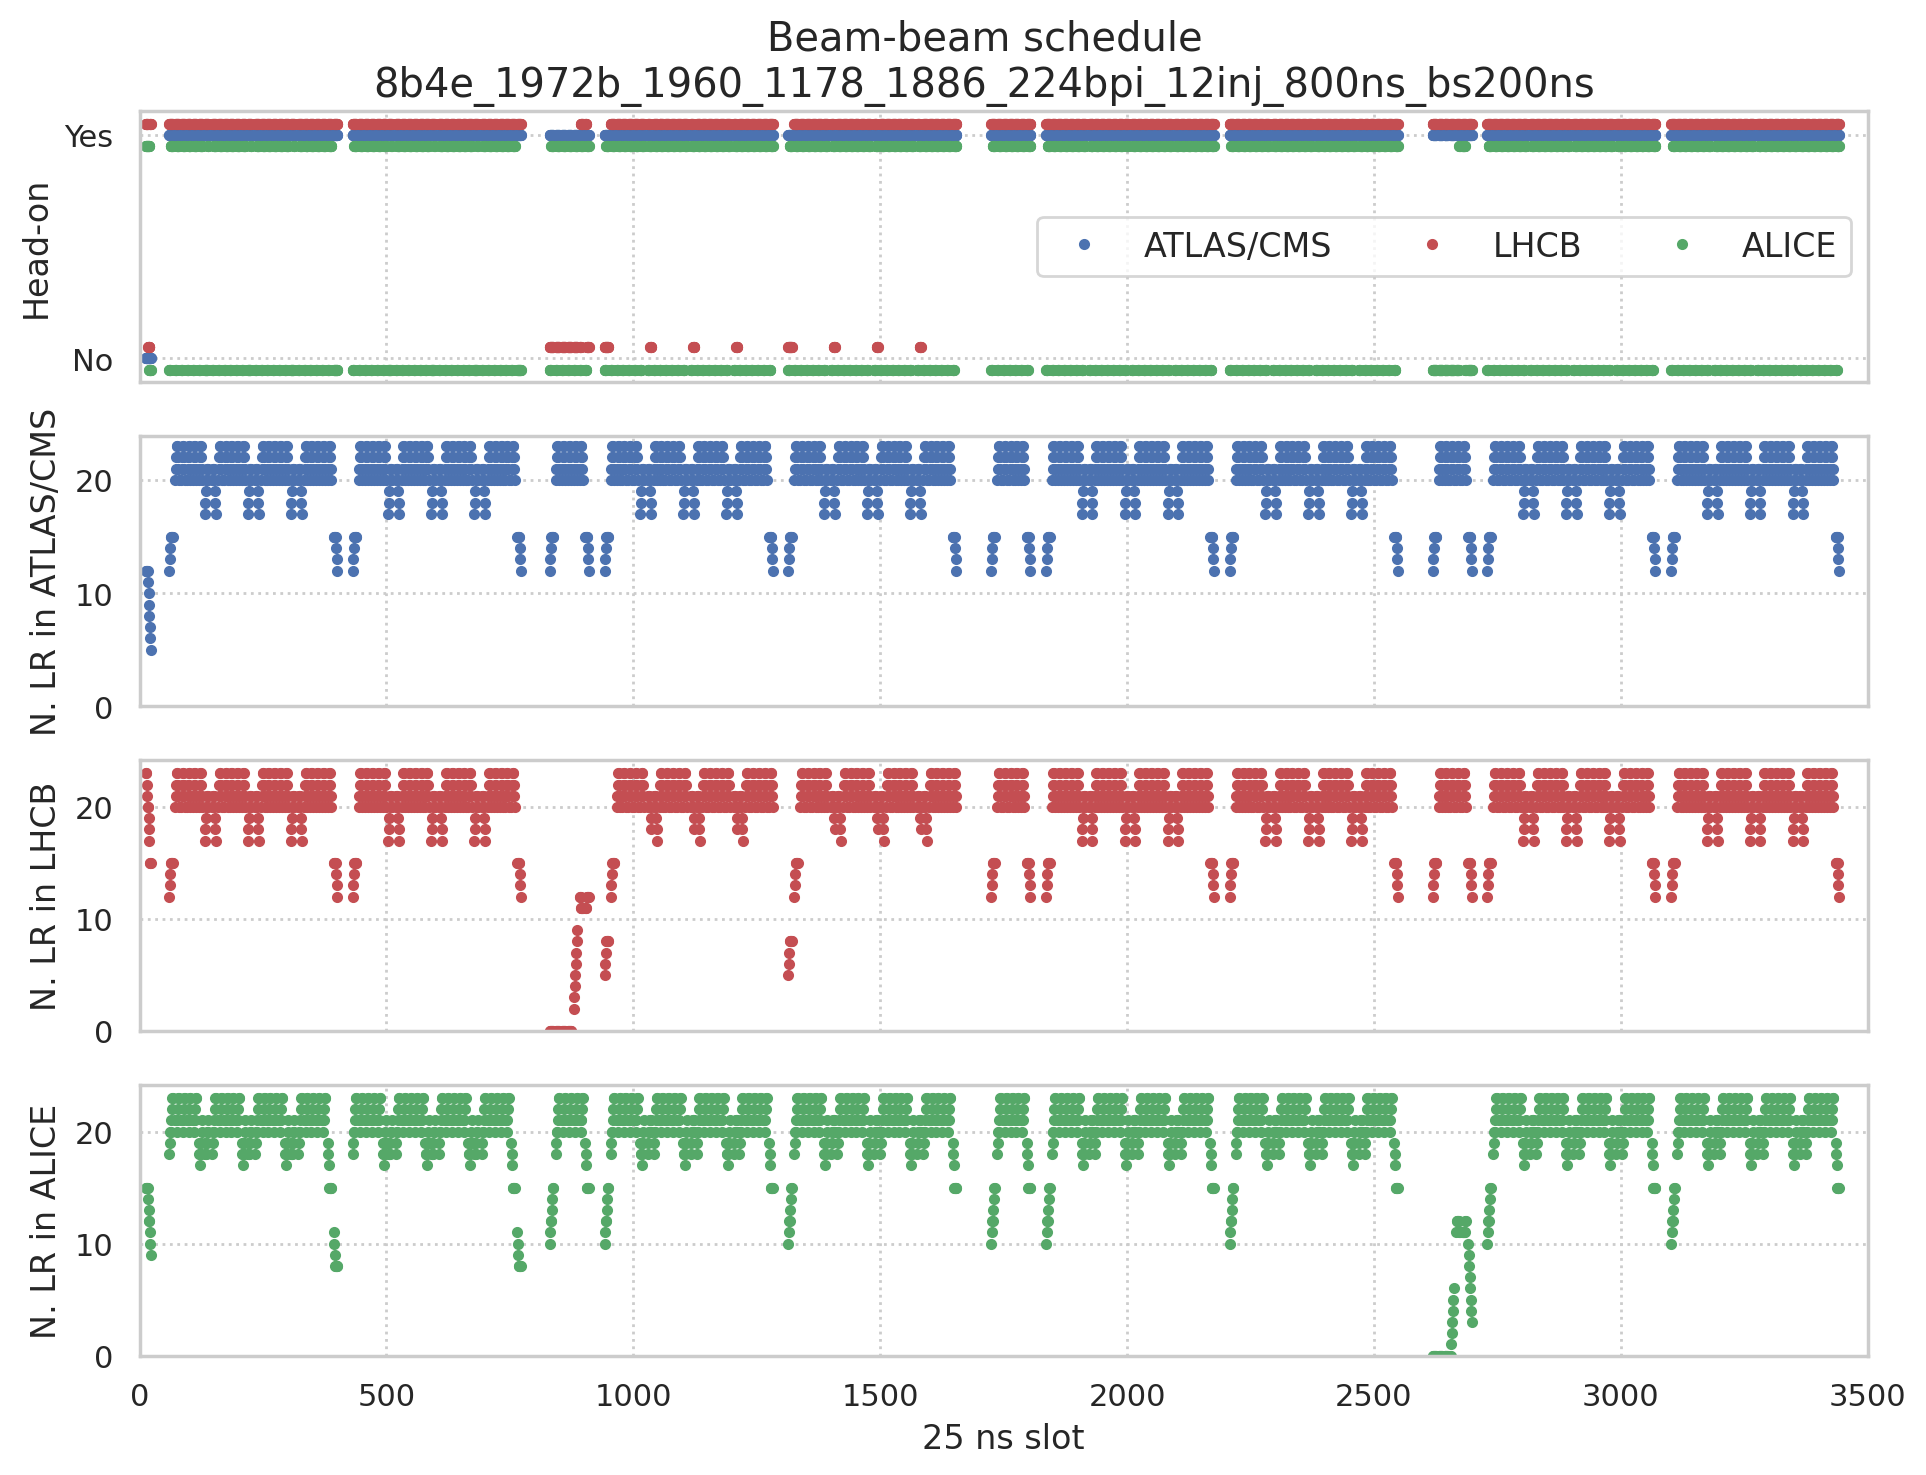

In [3]:
# Compute bb schedule
patt.compute_beam_beam_schedule(n_lr_per_side=16)

# Plot bb-schedule for beam 1
bbs = patt.b1.bb_schedule

fig1 = plt.figure(100, figsize=(6.4 * 1.5, 1.6 * 4.8))
ax1 = fig1.add_subplot(4, 1, 1)
ax2 = fig1.add_subplot(4, 1, 2, sharex=ax1)
ax3 = fig1.add_subplot(4, 1, 3, sharex=ax1)
ax4 = fig1.add_subplot(4, 1, 4, sharex=ax1)

ax1.plot(bbs["collides in ATLAS/CMS"], ".", color="b", label="ATLAS/CMS")
ax1.plot(0.05 + bbs["collides in LHCB"], ".", color="r", label="LHCB")
ax1.plot(-0.05 + bbs["collides in ALICE"], ".", color="g", label="ALICE")
ax1.legend(ncol=3, loc="center right", fontsize="medium")

ax1.plot(bbs["collides in ATLAS/CMS"], ".", color="b")
ax1.plot(0.05 + bbs["collides in LHCB"], ".", color="r")
ax1.plot(-0.05 + bbs["collides in ALICE"], ".", color="g")

ax2.plot(bbs["# of LR in ATLAS/CMS"], ".", color="b")
ax3.plot(bbs["# of LR in LHCB"], ".", color="r")
ax4.plot(bbs["# of LR in ALICE"], ".", color="g")

ax1.set_ylabel("Head-on")
ax2.set_ylabel("N. LR in ATLAS/CMS")
ax3.set_ylabel("N. LR in LHCB")
ax4.set_ylabel("N. LR in ALICE")

ax1.set_yticks([0, 1])
ax1.set_yticklabels(["No", "Yes"])
ax4.set_xlim(0, 3500)
ax4.set_xlabel("25 ns slot")

for aa in [ax1, ax2, ax3]:
    aa.tick_params(labelbottom=False)

for aa in [ax1, ax2, ax3, ax4]:
    aa.grid(True, linestyle=":")

for aa in [ax2, ax3, ax4]:
    aa.set_ylim(bottom=0)

fig1.subplots_adjust(left=0.06, right=0.96, top=0.92)
fig1.suptitle("Beam-beam schedule\n" + patt.scheme_name.split("/filling_scheme/")[1])
plt.show()


### Cluster the bunches according to their interaction pattern

First project variance in a lower-dimensional space with a non-linear methods (t-SNE or UMAP).

There are 6 coordinates contained in the bbs dataframe:
 1. collides in ATLAS/CMS
 2. collides in LHCB
 3. collides in ALICE
 4. nb of LR in ATLAS/CMS
 5. nb of LR in LHCB
 6. nb of LR in ALICE

These will be projected in a 2D space

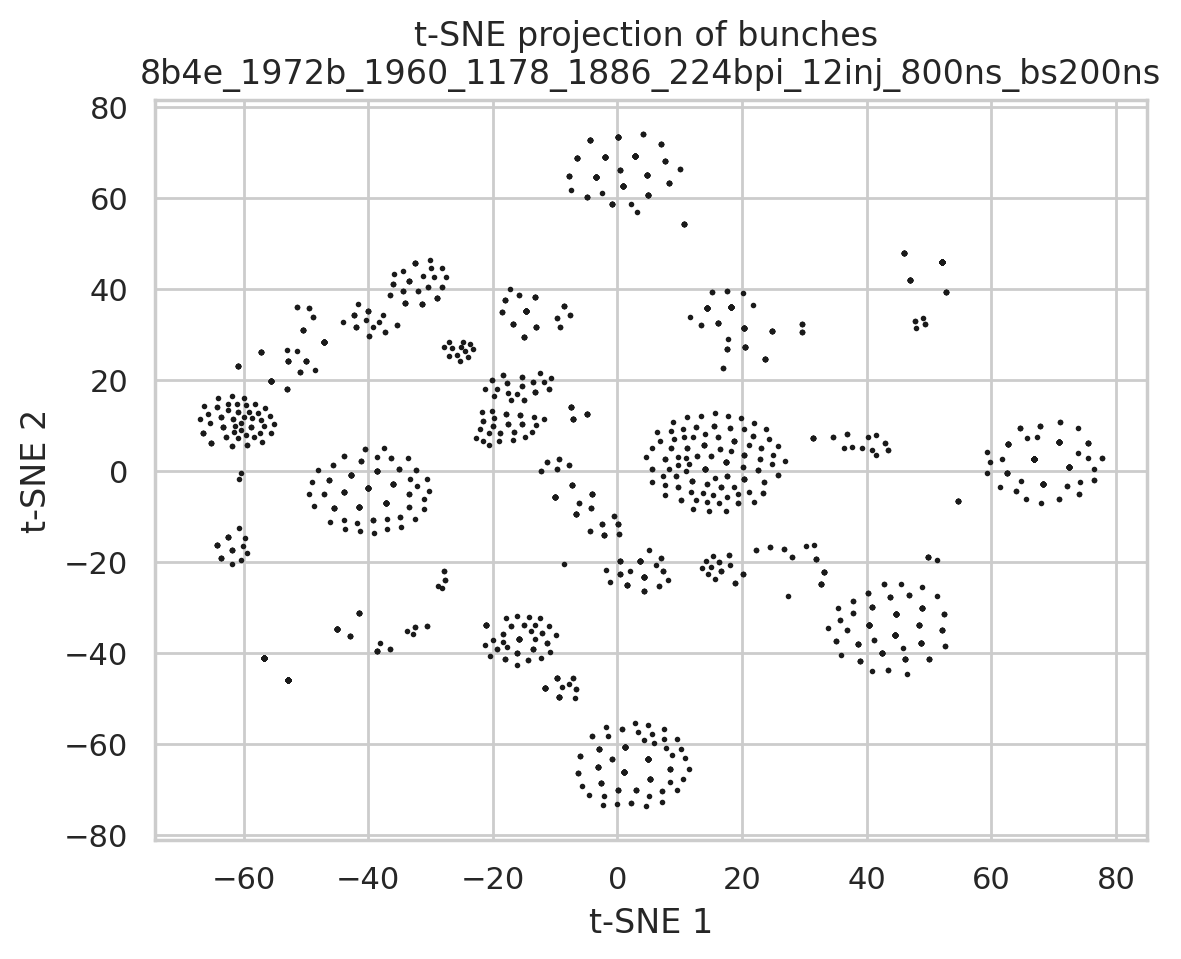

In [4]:
# Project bunches in 2D using t-sne
bbs = patt.b1.bb_schedule
array_bunches = np.array(
    [
        bbs["collides in ATLAS/CMS"],
        bbs["collides in LHCB"],
        bbs["collides in ALICE"],
        bbs["# of LR in ATLAS/CMS"],
        bbs["# of LR in LHCB"],
        bbs["# of LR in ALICE"],
    ],
    dtype=np.float32,
).T

# Add some noise to the data to prevent matrix singularity (with umap)
# array_bunches += np.random.normal(0, 0.001, array_bunches.shape)

# Rescale data to have unit variance
scaled_array_bunches = StandardScaler().fit_transform(array_bunches)

# Compute t-SNE projection
tsne = manifold.TSNE(
    n_components=2, perplexity=80, early_exaggeration=150, random_state=1, metric="manhattan"
)
array_bunches_2d = tsne.fit_transform(scaled_array_bunches)

# Plot tsne projection
fig = plt.figure()
plt.scatter(array_bunches_2d[:, 0], array_bunches_2d[:, 1], s=1, c="k")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE projection of bunches \n" + patt.scheme_name.split("/filling_scheme/")[1])
plt.show()


In [13]:
# Export list of bunches (e.g. to compute DA for each bunch)
bbs.to_csv("8b4e_1972b_1960_1178_1886_224bpi_12inj_800ns_bs200ns_bbs.csv", index_label="bunch number")

Then cluster using Gaussian mixtures models or K-means. Elbow method or bayesian information criterium didn't work well, so the number of cluster was chosen 'by eye'. Random state also had to be optimized.

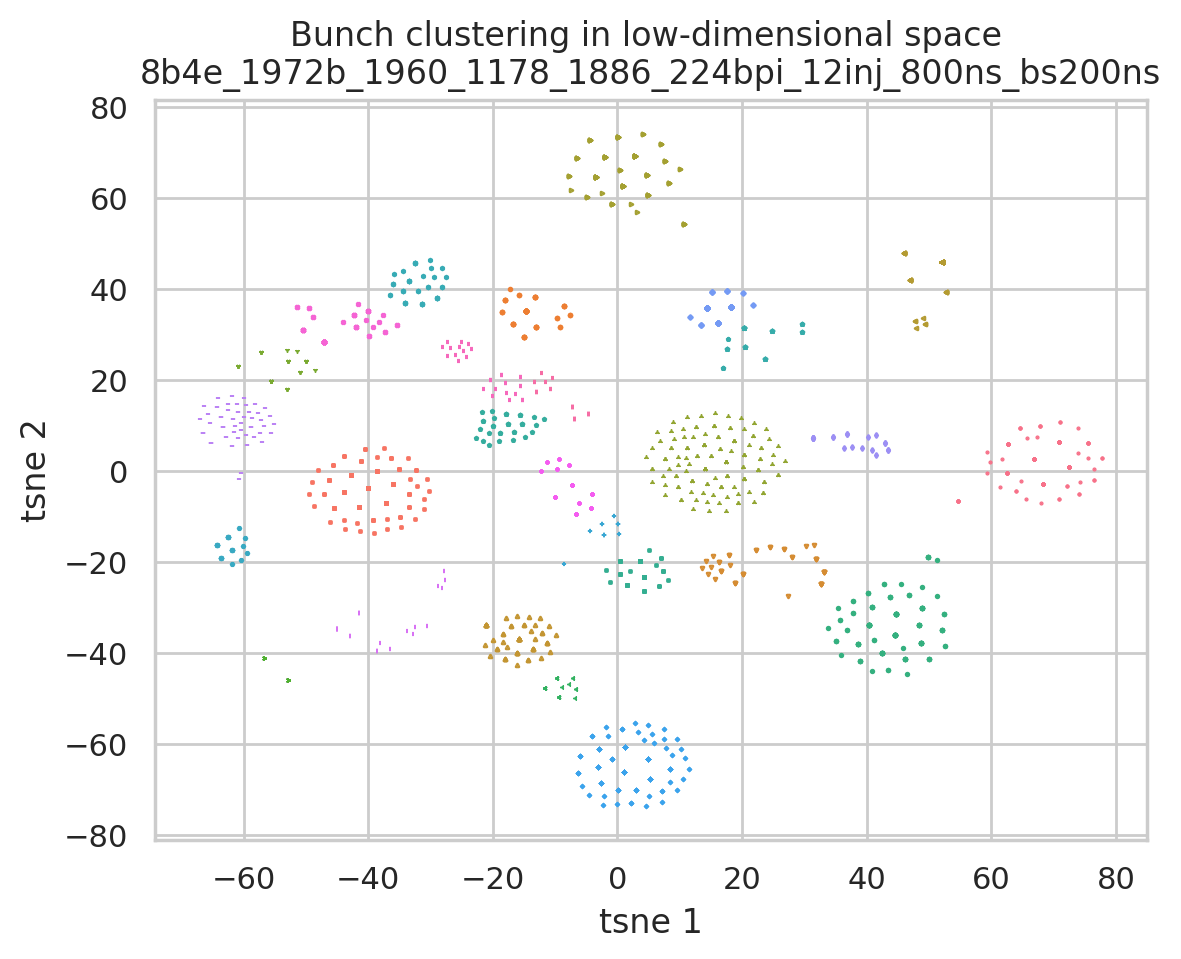

In [5]:
# Cluster the bunches in 27 clusters
n_clusters = 27
# kmeans = GaussianMixture(n_clusters=n_clusters, random_state=random_state).fit(array_bunches_2d)
gm_clusters = GaussianMixture(n_components=n_clusters, random_state=48, covariance_type="full").fit(
    array_bunches_2d
)
# bunches_labels = kmeans.labels_
bunches_labels = gm_clusters.predict(array_bunches_2d)
color_list = sns.color_palette("husl", n_clusters)
marker_list = list(Line2D.markers.keys())
# Plot the clusters in 2D
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(n_clusters):
    ax.scatter(
        array_bunches_2d[bunches_labels == i, 0],
        array_bunches_2d[bunches_labels == i, 1],
        label=f"cluster {i}",
        color=color_list[i],
        s=1,
        marker=marker_list[i],
    )
ax.set_xlabel("tsne 1")
ax.set_ylabel("tsne 2")
ax.set_title(
    "Bunch clustering in low-dimensional space \n" + patt.scheme_name.split("/filling_scheme/")[1]
)
plt.show()


For each cluster, find the centroid and the corresponding closest bunch.

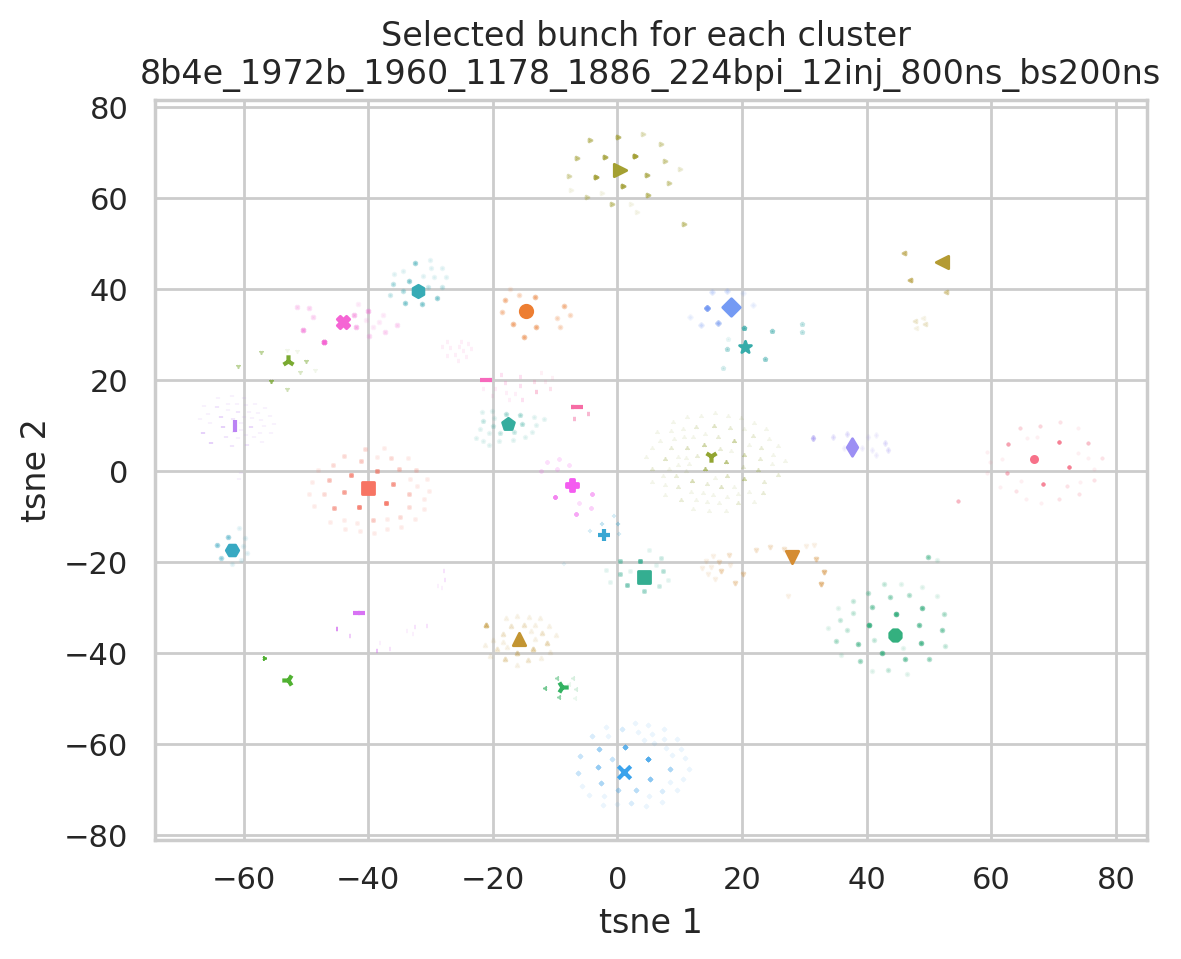

In [6]:
# Get the index of the point closest to the centroid of each cluster (using bunches_labels)
l_idx = []
for i in range(n_clusters):
    centroid = np.mean(array_bunches_2d[bunches_labels == i], axis=0)
    dist = np.sqrt(
        (array_bunches_2d[bunches_labels == i, 0] - centroid[0]) ** 2
        + (array_bunches_2d[bunches_labels == i, 1] - centroid[1]) ** 2
    )
    l_idx.append(np.argmin(dist))

# # Plot all the bunches along with the bunches selected in the previous step (in 2D)
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(n_clusters):
    ax.scatter(
        array_bunches_2d[bunches_labels == i, 0],
        array_bunches_2d[bunches_labels == i, 1],
        label=f"cluster {i}",
        color=color_list[i],
        s=1,
        marker=marker_list[i],
        alpha=0.1,
    )
    ax.scatter(
        array_bunches_2d[bunches_labels == i, 0][l_idx[i]],
        array_bunches_2d[bunches_labels == i, 1][l_idx[i]],
        label=f"cluster {i}",
        color=color_list[i],
        s=20,
        marker=marker_list[i],
    )
# ax.legend()
ax.set_xlabel("tsne 1")
ax.set_ylabel("tsne 2")
ax.set_title("Selected bunch for each cluster \n" + patt.scheme_name.split("/filling_scheme/")[1])
plt.show()


In [7]:
# Get the bunches corresponding to the index (keeping only the first one, as many bunches are identical)
l_bunches_selected = []
for i in range(n_clusters):
    # Get index in array_bunches_2d first
    array_cluster = array_bunches_2d[bunches_labels == i]

    # Get the list of clusters corresponding to the central bunch
    l_idx_centroids = np.where(
        (array_bunches_2d[:, 0] == array_cluster[l_idx[i]][0])
        & (array_bunches_2d[:, 1] == array_cluster[l_idx[i]][1])
    )[0]

    # Only keep one (they're all identical)
    idx = l_idx_centroids[0]

    # Add the corresponding index from the dataframe
    l_bunches_selected.append(bbs.index[idx])

print("List of selected bunches: ", l_bunches_selected)


List of selected bunches:  [76, 2754, 1731, 2682, 607, 77, 3342, 2053, 2803, 74, 1403, 2049, 139, 848, 1912, 398, 2633, 2300, 2854, 126, 897, 222, 1043, 154, 3435, 942, 1036]


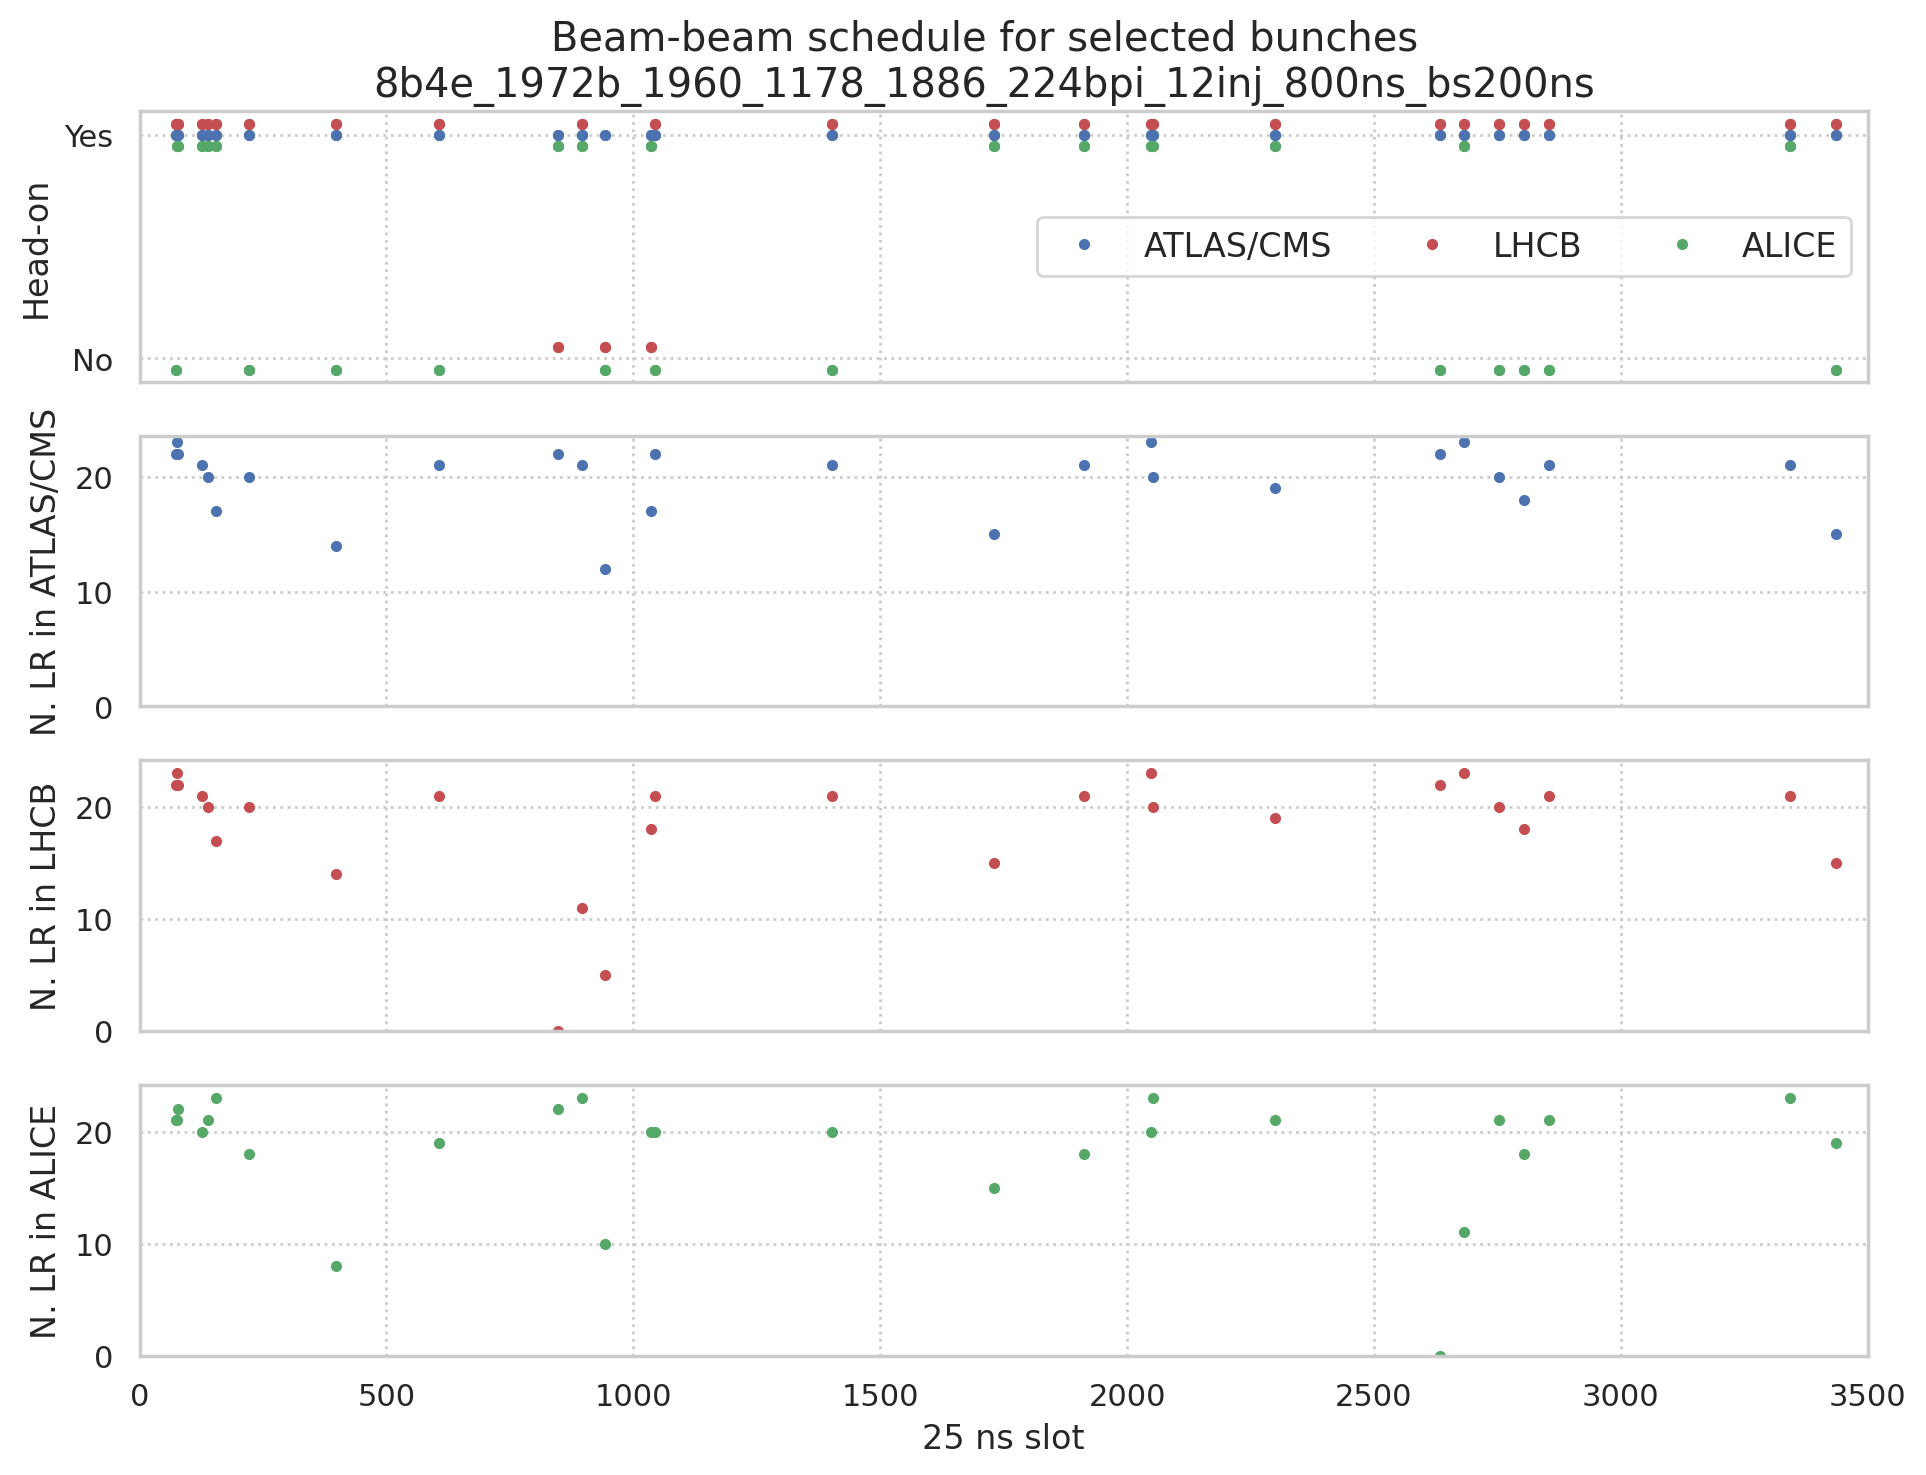

In [8]:
# Plot the interactions of the selected bunches
fig1 = plt.figure(100, figsize=(6.4 * 1.5, 1.6 * 4.8))
ax1 = fig1.add_subplot(4, 1, 1)
ax2 = fig1.add_subplot(4, 1, 2, sharex=ax1)
ax3 = fig1.add_subplot(4, 1, 3, sharex=ax1)
ax4 = fig1.add_subplot(4, 1, 4, sharex=ax1)

ax1.plot(bbs["collides in ATLAS/CMS"][l_bunches_selected], ".", color="b", label="ATLAS/CMS")
ax1.plot(0.05 + bbs["collides in LHCB"][l_bunches_selected], ".", color="r", label="LHCB")
ax1.plot(-0.05 + bbs["collides in ALICE"][l_bunches_selected], ".", color="g", label="ALICE")
ax1.legend(ncol=3, loc="center right", fontsize="medium")

ax1.plot(bbs["collides in ATLAS/CMS"][l_bunches_selected], ".", color="b")
ax1.plot(0.05 + bbs["collides in LHCB"][l_bunches_selected], ".", color="r")
ax1.plot(-0.05 + bbs["collides in ALICE"][l_bunches_selected], ".", color="g")

ax2.plot(bbs["# of LR in ATLAS/CMS"][l_bunches_selected], ".", color="b")
ax3.plot(bbs["# of LR in LHCB"][l_bunches_selected], ".", color="r")
ax4.plot(bbs["# of LR in ALICE"][l_bunches_selected], ".", color="g")

ax1.set_ylabel("Head-on")
ax2.set_ylabel("N. LR in ATLAS/CMS")
ax3.set_ylabel("N. LR in LHCB")
ax4.set_ylabel("N. LR in ALICE")

ax1.set_yticks([0, 1])
ax1.set_yticklabels(["No", "Yes"])
ax4.set_xlim(0, 3500)
ax4.set_xlabel("25 ns slot")

for aa in [ax1, ax2, ax3]:
    aa.tick_params(labelbottom=False)

for aa in [ax1, ax2, ax3, ax4]:
    aa.grid(True, linestyle=":")

for aa in [ax2, ax3, ax4]:
    aa.set_ylim(bottom=0)

fig1.subplots_adjust(left=0.06, right=0.96, top=0.92)
fig1.suptitle(
    "Beam-beam schedule for selected bunches\n" + patt.scheme_name.split("/filling_scheme/")[1]
)
plt.show()


### Plot the clustered bunches on the DA figure for WP (62.316, 60.321)

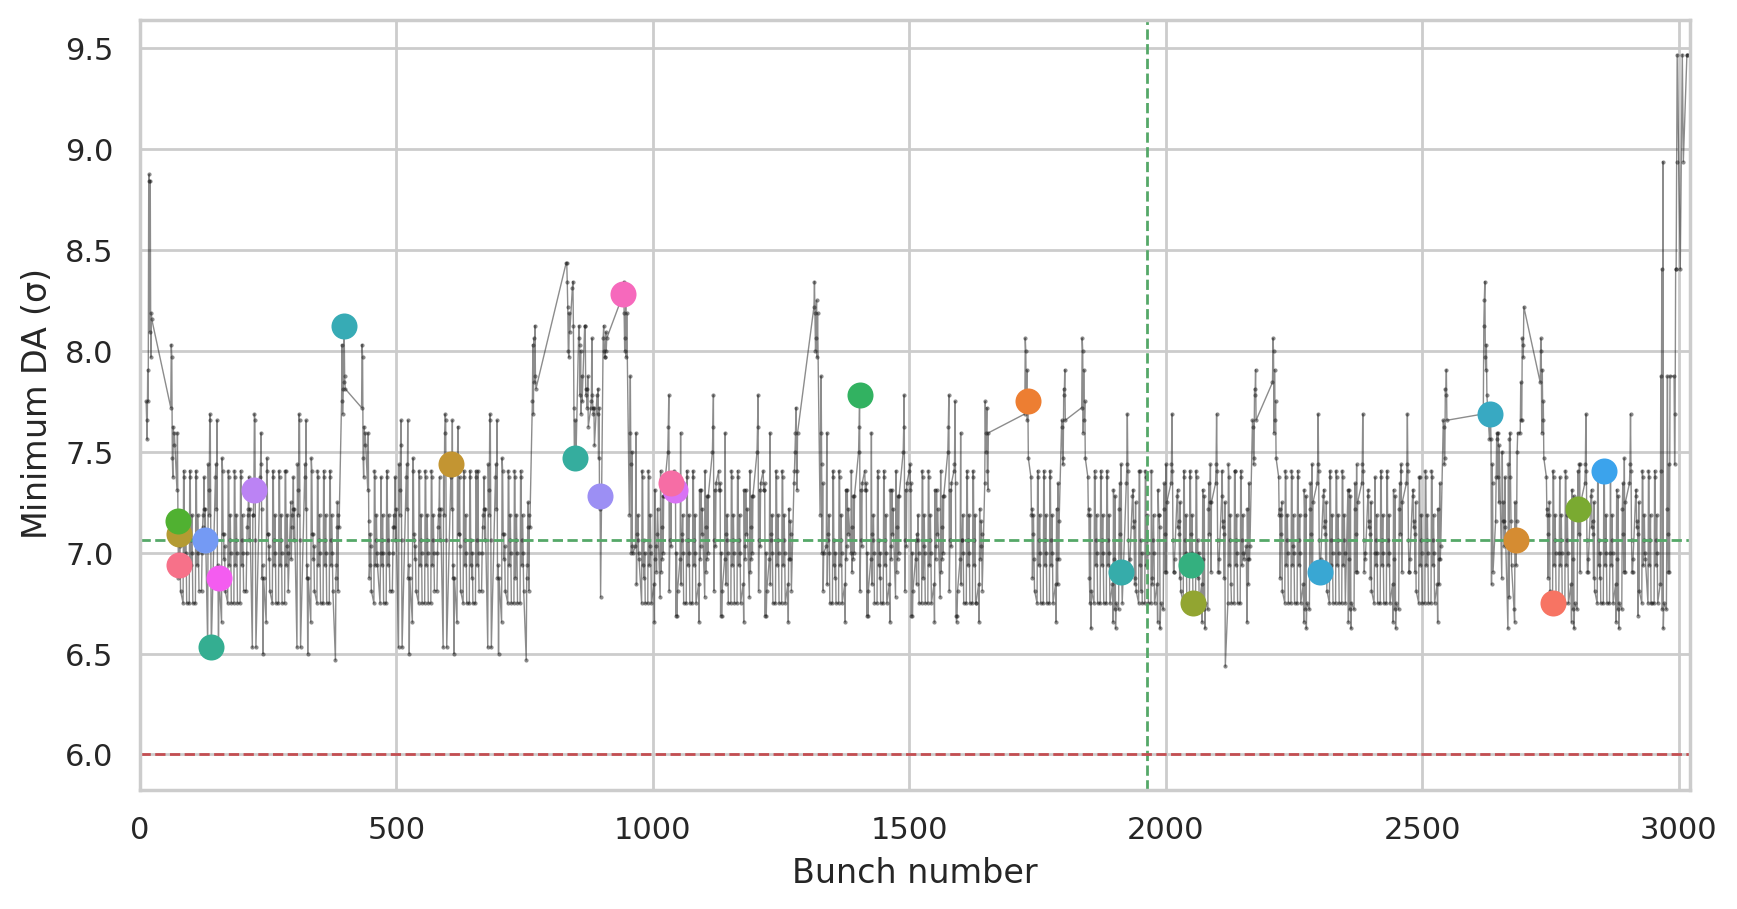

In [9]:
df_DA_mini = pd.read_parquet("daEOL_opt_flathv_75_1500_withBB_chroma5_filling.parquet")
df_DA_mini.sort_values(by="bunch_nb", inplace=True)

fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(10, 5))
plt.plot(
    df_DA_mini["bunch_nb"].values,
    df_DA_mini["normalized amplitude in xy-plane"].values,
    linestyle="-",
    lw=0.5,
    marker=".",
    ms=1,
    c="k",
    alpha=0.5,
)
for i, bunch_nb in enumerate(l_bunches_selected):
    try:
        plt.scatter(
            bunch_nb,
            df_DA_mini[df_DA_mini["bunch_nb"] == int(bunch_nb)][
                "normalized amplitude in xy-plane"
            ].values[0],
            marker="o",
            s=70,
            # c="g",
            color=color_list[i],
            linewidths=1,
            zorder=10,
        )
    except:
        pass

plt.axhline(
    df_DA_mini[df_DA_mini["bunch_nb"] == 1963]["normalized amplitude in xy-plane"].values[0],
    c="g",
    ls="--",
    lw=1,
)
plt.axvline(1963, c="g", ls="--", lw=1)
plt.axhline(6, c="r", lw=1, ls="--")
plt.xlim(0, df_DA_mini["bunch_nb"][-1] + 1)
plt.ylabel(r"Minimum DA $\rm (\sigma)$")
plt.xlabel("Bunch number")
plt.show()


Only keep the 20 cluster with the highest cardinal, because the colors are not distinguishable anymore.

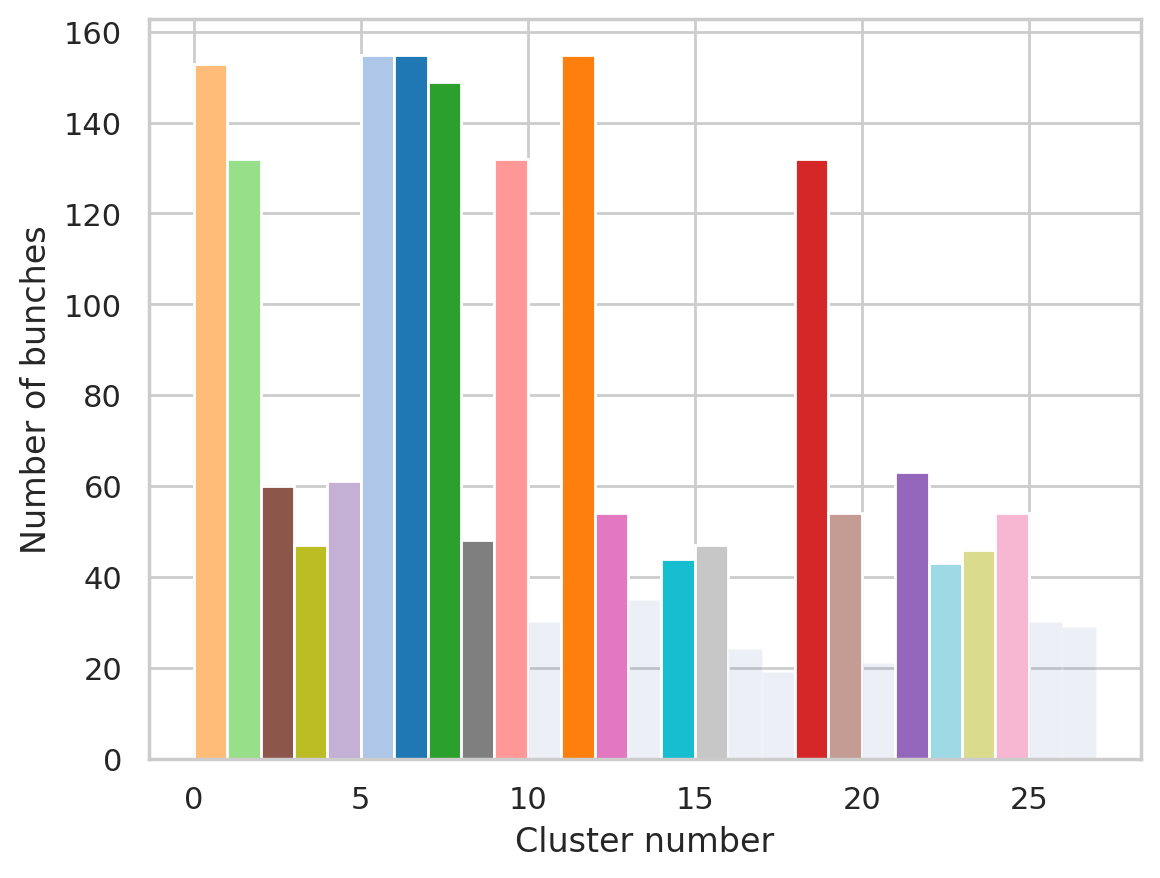

In [10]:
counts, bins = np.histogram(bunches_labels, bins=np.arange(n_clusters + 1))
N, bins, patches = plt.hist(bins[:-1], bins, weights=counts)

# Now, get the indices of the 20 most populated clusters
l_idx = np.argsort(counts)[::-1][:20]

# Set to go faster
set_idx = set(l_idx)

# Get a list of 20 colors
color_list = plt.cm.tab20(np.linspace(0, 1, len(l_idx)))

# Associate each of the most populated clusters with a color
dic_color = dict(zip(l_idx, color_list))

for i, (counts, thispatch) in enumerate(zip(counts, patches)):
    if i not in l_idx:
        thispatch.set_alpha(0.1)
    else:
        thispatch.set_facecolor(dic_color[i])


plt.xlabel("Cluster number")
plt.ylabel("Number of bunches")
plt.show()


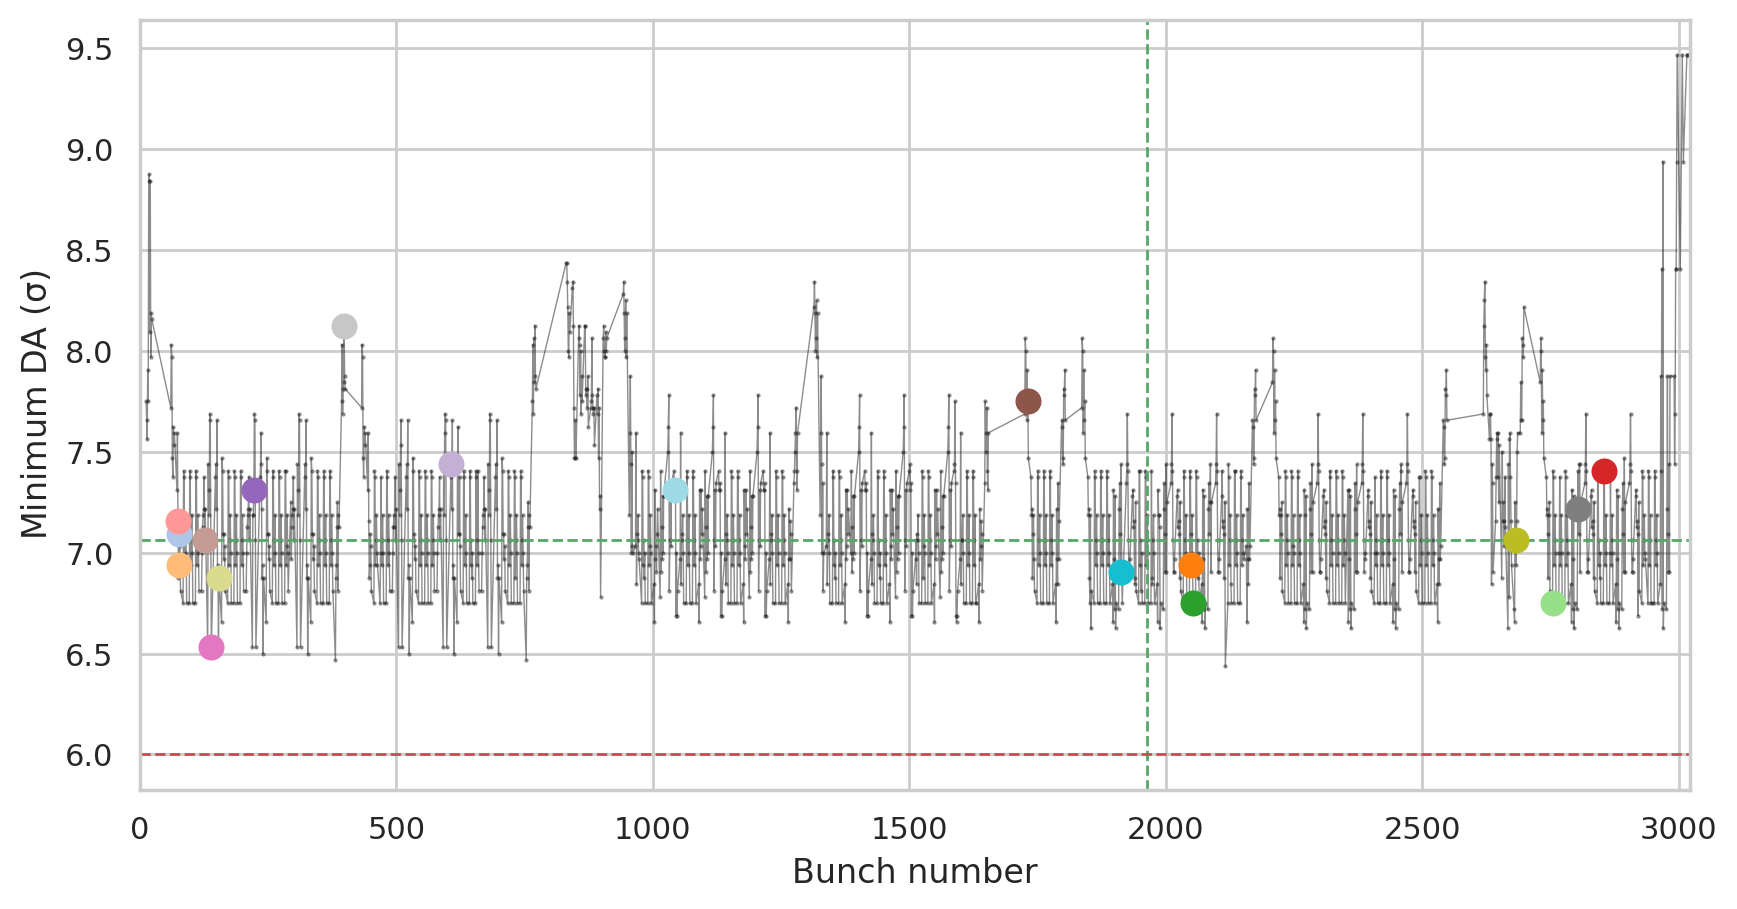

In [11]:
fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(10, 5))
plt.plot(
    df_DA_mini["bunch_nb"].values,
    df_DA_mini["normalized amplitude in xy-plane"].values,
    linestyle="-",
    lw=0.5,
    marker=".",
    ms=1,
    c="k",
    alpha=0.5,
)
for i, bunch_nb in enumerate(l_bunches_selected):
    try:
        if i in set_idx:
            plt.scatter(
                bunch_nb,
                df_DA_mini[df_DA_mini["bunch_nb"] == int(bunch_nb)][
                    "normalized amplitude in xy-plane"
                ].values[0],
                marker="o",
                s=70,
                color=dic_color[i],
                linewidths=1,
                zorder=10,
            )
    except:
        pass

plt.axhline(
    df_DA_mini[df_DA_mini["bunch_nb"] == 1963]["normalized amplitude in xy-plane"].values[0],
    c="g",
    ls="--",
    lw=1,
)
plt.axvline(1963, c="g", ls="--", lw=1)
plt.axhline(6, c="r", lw=1, ls="--")
plt.xlim(0, df_DA_mini["bunch_nb"][-1] + 1)
plt.ylabel(r"Minimum DA $\rm (\sigma)$")
plt.xlabel("Bunch number")
plt.show()


Same plot coloring all the bunchs according to their cluster.

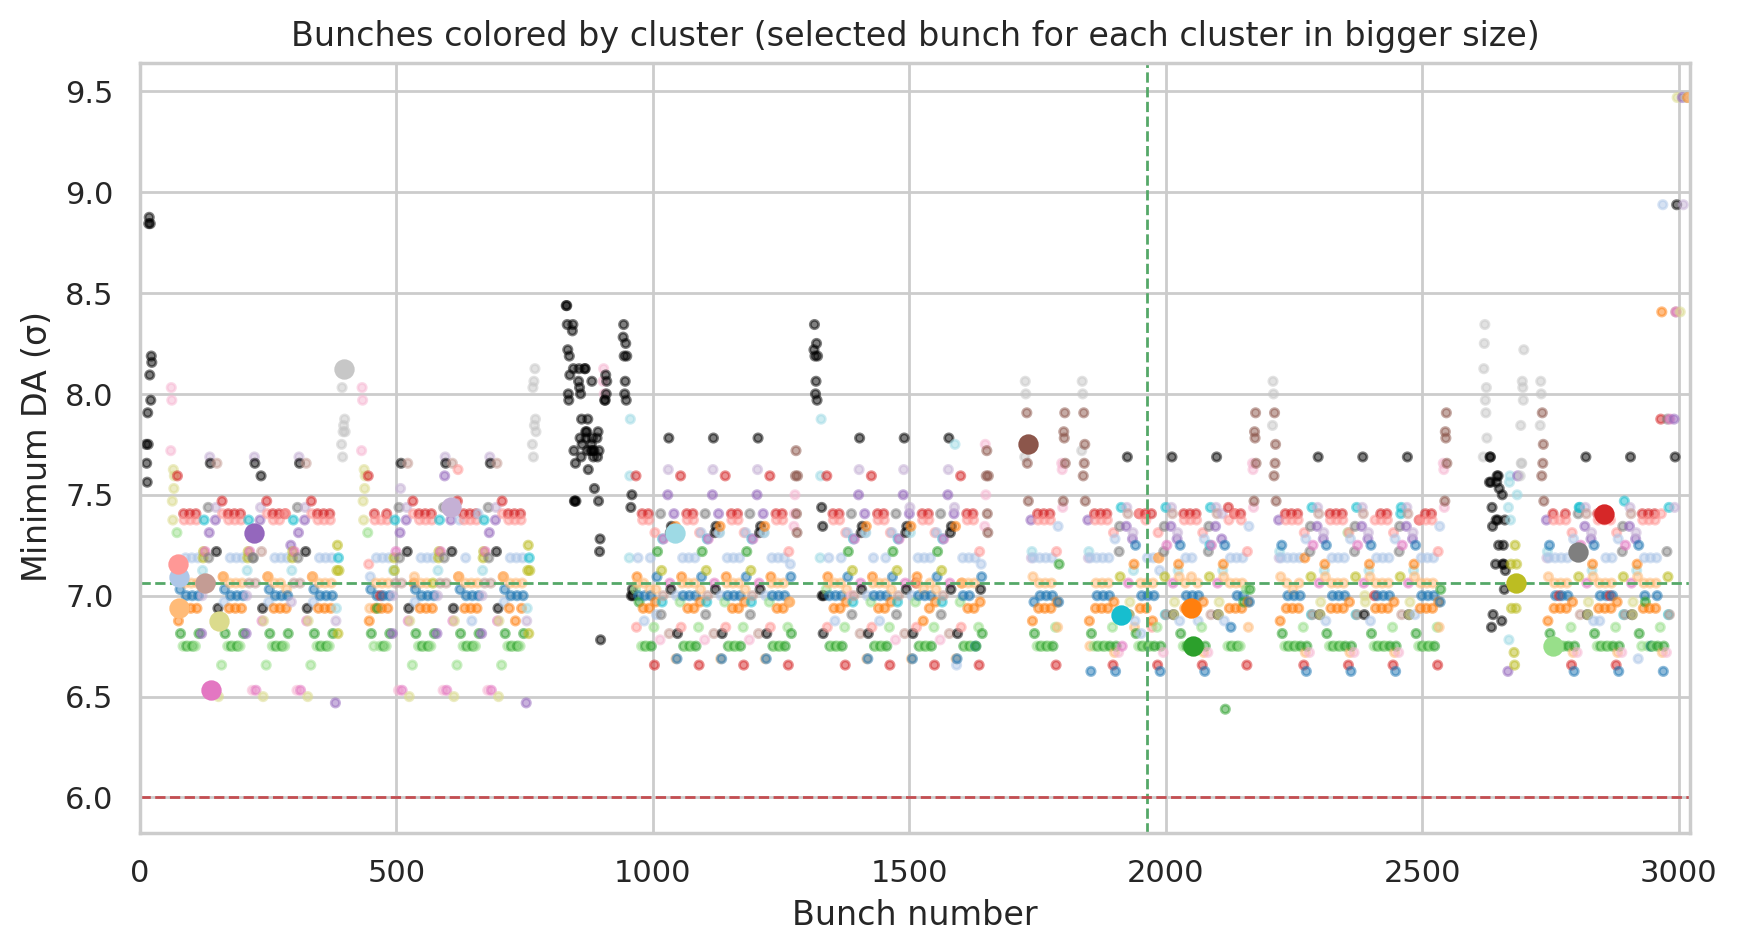

In [12]:
fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(10, 5))
plt.scatter(
    df_DA_mini["bunch_nb"].values,
    df_DA_mini["normalized amplitude in xy-plane"].values,
    linestyle="-",
    # lw=0.5,
    marker=".",
    # ms=1,
    c=[
        dic_color[x] if x in set_idx else np.array([0.0, 0.0, 0.0, 0.1])
        for x in bunches_labels[: len(df_DA_mini["bunch_nb"].values)]
    ],
    alpha=0.5,
)


for i, bunch_nb in enumerate(l_bunches_selected):
    try:
        if i in set_idx:
            plt.scatter(
                bunch_nb,
                df_DA_mini[df_DA_mini["bunch_nb"] == int(bunch_nb)][
                    "normalized amplitude in xy-plane"
                ].values[0],
                marker="o",
                s=40,
                color=dic_color[i],
                linewidths=1,
                zorder=10,
            )
    except:
        pass

plt.axhline(
    df_DA_mini[df_DA_mini["bunch_nb"] == 1963]["normalized amplitude in xy-plane"].values[0],
    c="g",
    ls="--",
    lw=1,
)
plt.axvline(1963, c="g", ls="--", lw=1)
plt.axhline(6, c="r", lw=1, ls="--")
plt.xlim(0, df_DA_mini["bunch_nb"][-1] + 1)
plt.ylabel(r"Minimum DA $\rm (\sigma)$")
plt.xlabel("Bunch number")
plt.title("Bunches colored by cluster (selected bunch for each cluster in bigger size)")
plt.show()


### Check DA distribution for each cluster

In [13]:
import string

# Build dataframe containing the DA values and the corresponding cluster
df_bunches = pd.DataFrame(
    {
        "DA": df_DA_mini["normalized amplitude in xy-plane"].values,
        "cluster": bunches_labels[: len(df_DA_mini["bunch_nb"].values)],
    }
)

# Add a column with mean DA by cluster
df_bunches["mean DA"] = df_bunches.groupby("cluster")["DA"].transform("mean")

# Sort by mean DA
df_bunches = df_bunches.sort_values(by="mean DA", ascending=True)

# # Reasign the cluster number acording to the mean DA
# df_bunches["cluster"] = df_bunches["cluster"].map(
#     dict(zip(df_bunches["cluster"].unique(), np.arange(len(df_bunches["cluster"].unique()))))
# )

# Add a column with the cluster letter
df_bunches["cluster letter"] = df_bunches["cluster"].map(
    dict(
        zip(
            df_bunches["cluster"].unique(),
            list(string.ascii_uppercase)[: len(df_bunches["cluster"].unique())],
        )
    )
)

# Replace nan with £
df_bunches["cluster letter"] = df_bunches["cluster letter"].fillna("£")


df_bunches[200:300]


,DA,cluster,mean DA,cluster letter
603,6.75000,7,6.799395,B
1171,6.75000,7,6.799395,B
1115,6.75000,7,6.799395,B
1091,6.81250,7,6.799395,B
1147,6.81250,7,6.799395,B
...,...,...,...,...
842,7.09375,6,6.977644,C
770,7.00000,6,6.977644,C
370,7.00000,6,6.977644,C
1170,7.00000,6,6.977644,C


/tmp/ipykernel_2207119/2738685187.py:11: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x="cluster letter", y="DA", data=df_bunches, jitter=True, size = 1, palette=palette)


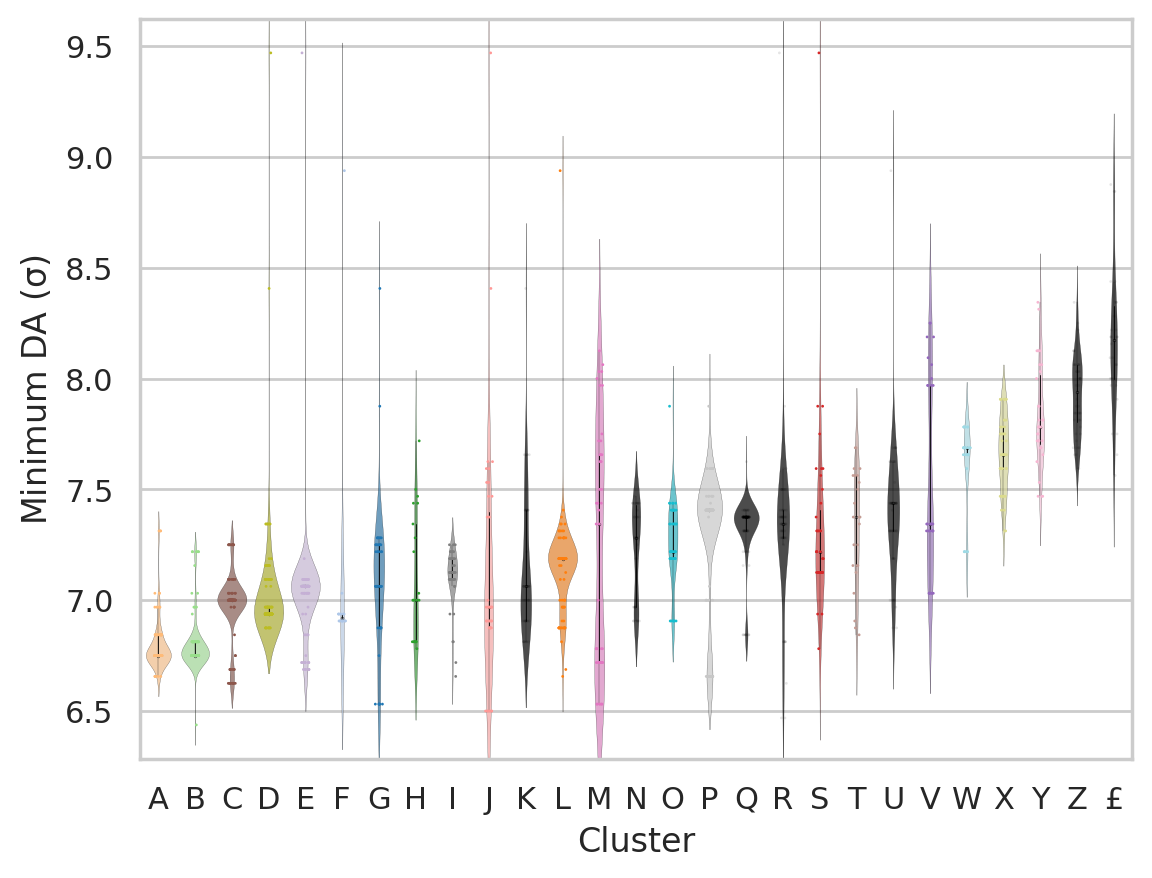

In [14]:
# Make a violin plot to see the distribution of DA values by cluster
palette = [
        dic_color[x] if x in set_idx else np.array([0.0, 0.0, 0.0, 0.1])
        for x in sorted(df_bunches["cluster"].unique())]
pal = sns.cubehelix_palette(27, rot=-0.25, light=0.7)
ax = sns.violinplot(
    x="cluster letter", y="DA", data=df_bunches, scale="count", inner="box", linewidth=0.1, palette=palette
    
)
plt.setp(ax.collections, alpha=.7)
sns.stripplot(x="cluster letter", y="DA", data=df_bunches, jitter=True, size = 1, palette=palette)
#ax.get_legend().remove()
plt.xlabel("Cluster")
plt.ylabel(r"Minimum DA $\rm (\sigma)$")
plt.show()


### Check how tune shift depends on clusterss

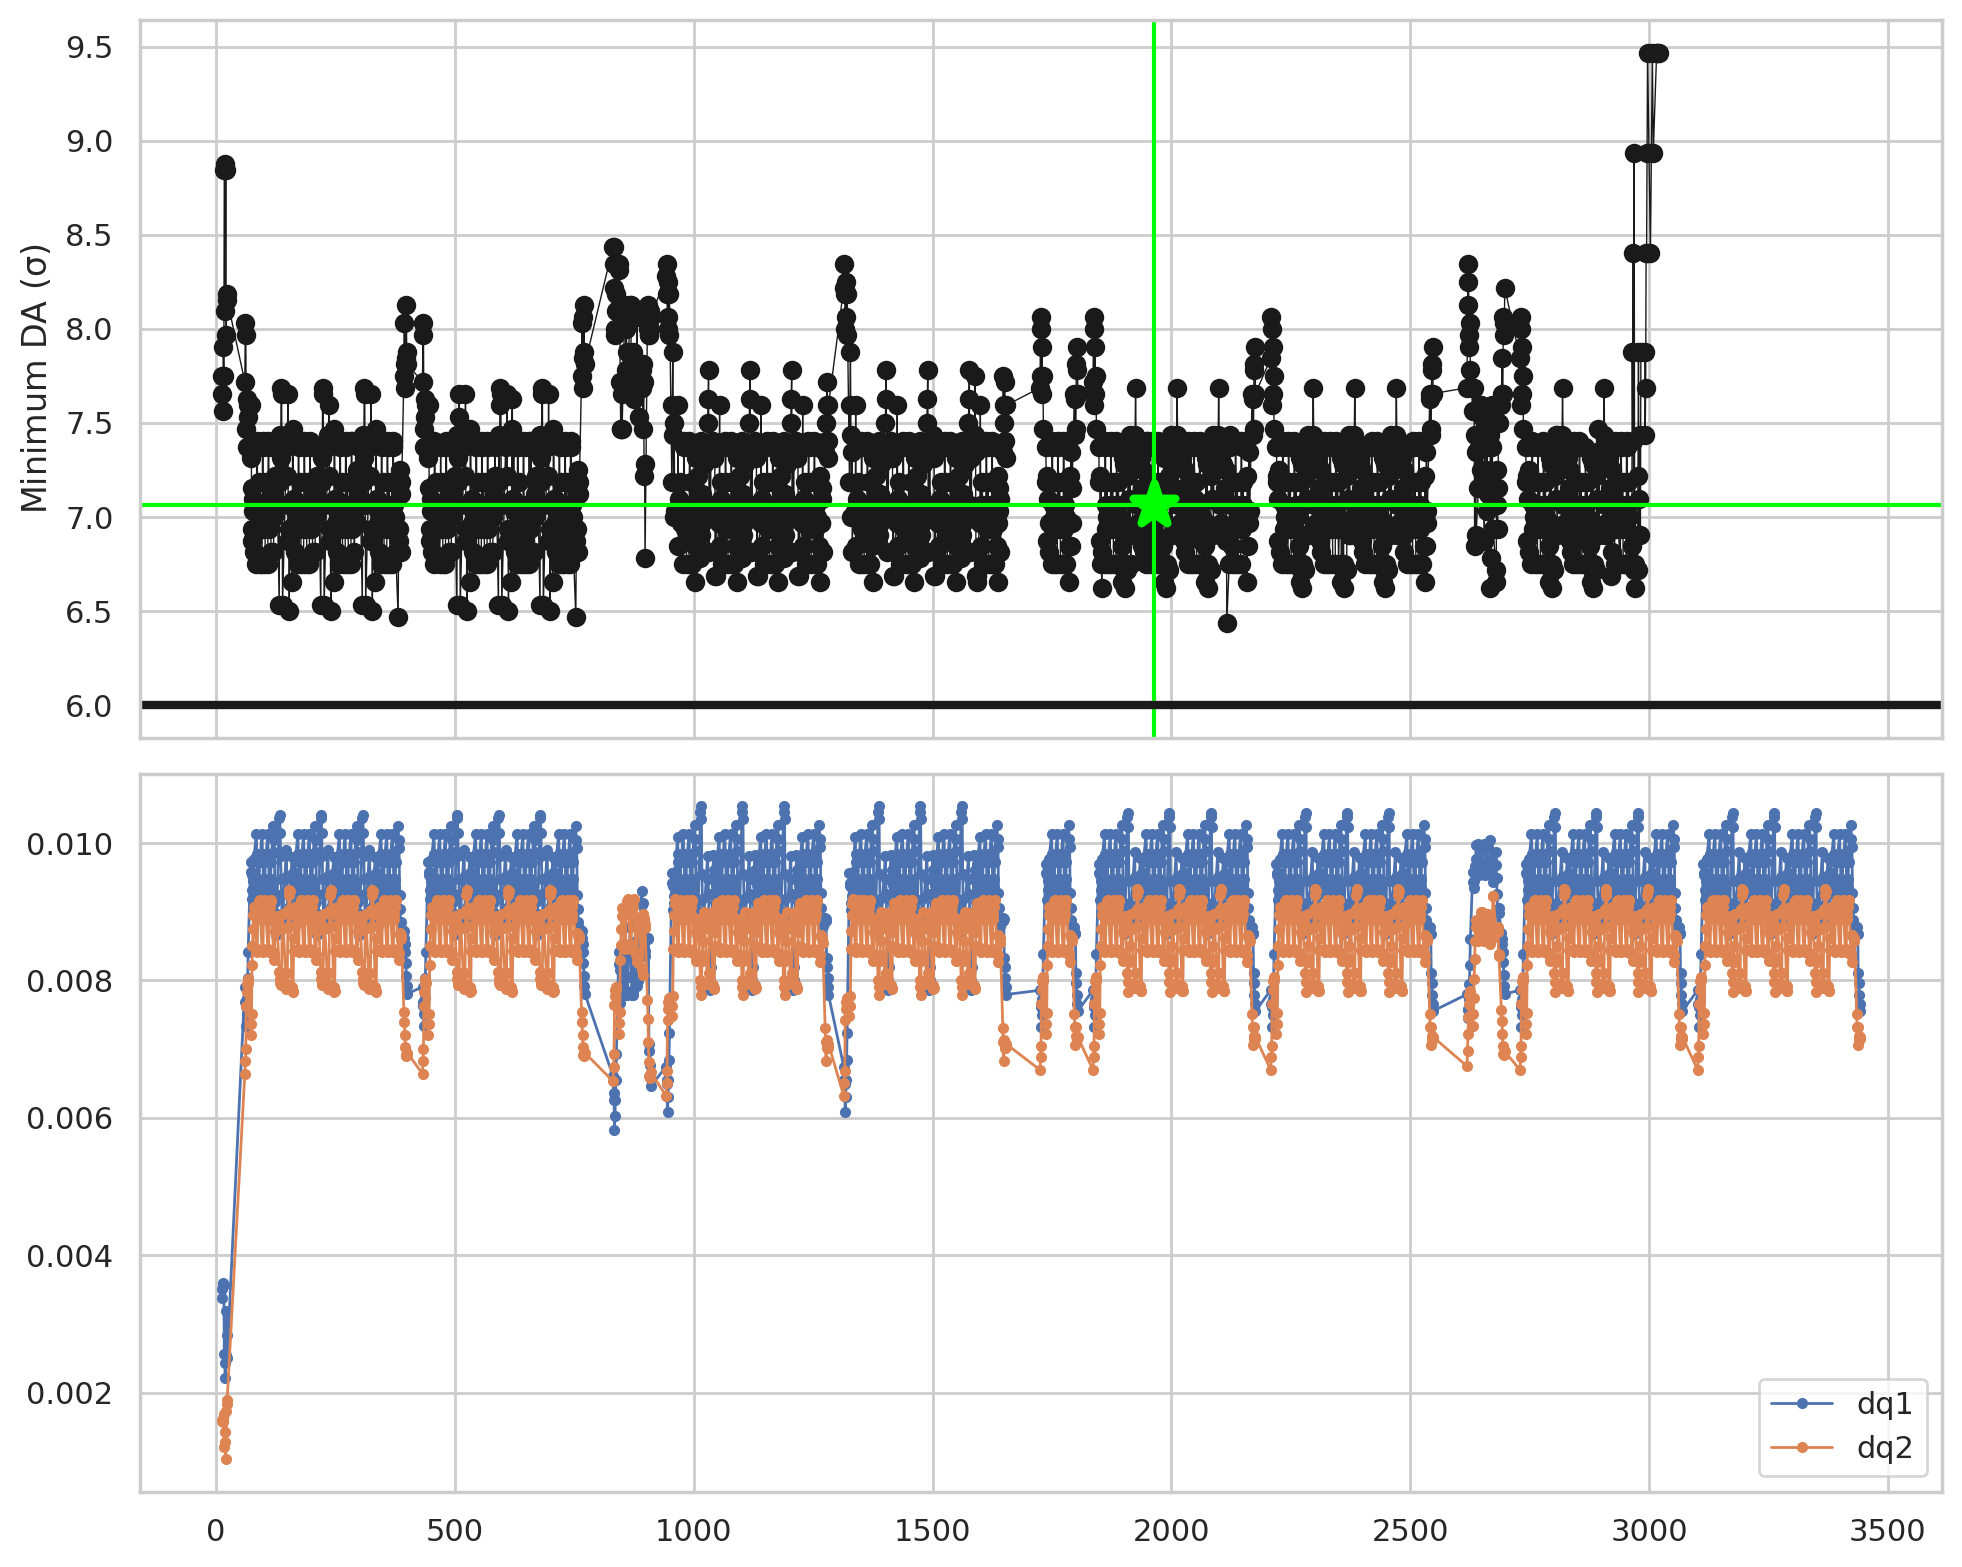

In [20]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10, 8))
df_DA = pd.read_parquet("daEOL_opt_flathv_75_1500_withBB_chroma5_filling.parquet")
df_DA.sort_values(by="bunch_nb", inplace=True)
plt.sca(ax[0])
plt.plot(df_DA["bunch_nb"].values, df_DA["normalized amplitude in xy-plane"].values, linestyle='-', lw=0.5, marker='o', ms=6, c='k')
plt.scatter(1963, df_DA[df_DA["bunch_nb"] == 1963]["normalized amplitude in xy-plane"].values[0], marker='*', s=250, c='lime', linewidths=3, zorder=10)
plt.axhline(df_DA[df_DA["bunch_nb"] == 1963]["normalized amplitude in xy-plane"].values[0], c='lime')
plt.axvline(1963, c='lime')
plt.axhline(6, c='k', lw=3)
plt.ylabel(r"Minimum DA $\rm (\sigma)$")
plt.sca(ax[1])
df_dq = pd.read_parquet("dq.parquet")
plt.plot(df_dq['bunch_nb'], df_dq['q1'], label="dq1", linestyle='-', lw=1, marker='o', markersize=3)
plt.plot(df_dq['bunch_nb'], df_dq['q2'], label="dq2", linestyle='-', lw=1, marker='o', markersize=3)
plt.legend()
#plt.xlim(1500, 2800)
fig.tight_layout()
plt.show()

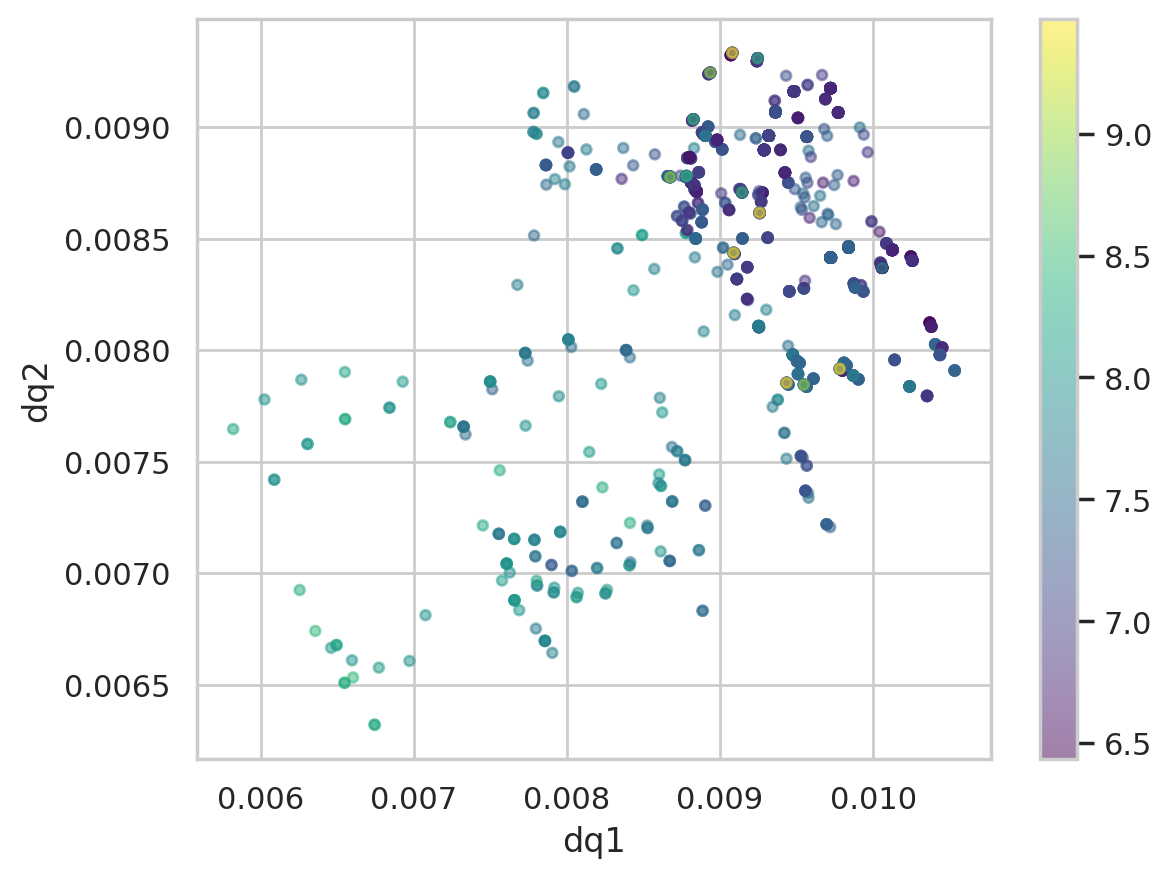

In [25]:
# Plot dq1 against dq2
N = len(df_DA["normalized amplitude in xy-plane"])
plt.scatter(df_dq['q1'][50:N], df_dq['q2'][50:N], c = df_DA["normalized amplitude in xy-plane"].values[50:], marker='.', s=50, alpha = 0.5, cmap = 'viridis')
plt.colorbar()
plt.xlabel("dq1")
plt.ylabel("dq2")
plt.show()

In [17]:
df['bunch_nb']

0         12
1         13
2         14
3         15
4         16
        ... 
1967    3438
1968    3439
1969    3440
1970    3441
1971    3442
Name: bunch_nb, Length: 1972, dtype: int64

In [18]:
df = pd.read_parquet("daEOL_opt_flathv_75_1500_withBB_chroma5_filling.parquet")
df.sort_values(by="bunch_nb", inplace=True)
df['bunch_nb']

name 1
madx_000       12.0
madx_001       13.0
madx_002       14.0
madx_003       15.0
madx_004       16.0
              ...  
madx_1704    3007.0
madx_1706    3009.0
madx_1709    3016.0
madx_1710    3017.0
madx_1714    3021.0
Name: bunch_nb, Length: 1705, dtype: float64